In [1]:
import pandas as pd
import unidecode
from typing import Optional
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
import networkx as nx
from itertools import combinations

Coisas a pensar: os orientados foram os selecionados pelo filtro, os orientadores nao necessariamente

In [2]:
DATA_DIR = '../data/'

In [3]:
# function to read the Lattes dataset
def read_dataset(
    data_dir,
    scope,
    dataset
):
    
    data_path = f'{data_dir}processed/{scope}/{dataset}.csv'
    df = pd.read_csv(data_path)
    return df

In [4]:
# function to standardize any string
standardize_string = lambda x: unidecode.unidecode(x.lower())

### Load and processing "orientacoes" dataframe

In [5]:
scope = 'aplicacoes' #current scope

# dataframe of supervision
df_orien = read_dataset(data_dir=DATA_DIR, scope=scope, dataset='orientacoes')

In [6]:
# select only completed supervisions
df_orien = df_orien[df_orien['STATUS'] == 'CONCLUIDA']

Obs: separar depois os grafos por tipo de orientacao (NATUREZA) caso ache necessario

In [7]:
df_orien = df_orien[['LattesID', 'NomeDoOrientador', 'NumeroIdOrientado']]

In [8]:
df_orien = df_orien.rename({'LattesID': 'LattesID_Orientando',
                            'NumeroIdOrientado': 'LattesID_Orientador'}, axis=1)

In [9]:
# fillna of NomeDoOrientador
df_orien['NomeDoOrientador'] = df_orien['NomeDoOrientador'].fillna('orientador com nome nao preenchido')

In [10]:
df_orien['NomeDoOrientador'] = df_orien['NomeDoOrientador'].apply(standardize_string)

In [11]:
null_number = -100000

In [12]:
# Convert Lattes ID to string
df_orien['LattesID_Orientador'] = df_orien['LattesID_Orientador'].fillna(null_number)
df_orien['LattesID_Orientador'] = df_orien['LattesID_Orientador'].astype('int')

In [13]:
df_orien.dtypes

LattesID_Orientando     int64
NomeDoOrientador       object
LattesID_Orientador     int64
dtype: object

### Load and processing general dataframe

In [14]:
# dataframe of general data
df_geral = read_dataset(data_dir=DATA_DIR, scope=scope, dataset='gerais')[['LattesID', 'NOME-COMPLETO']]

In [15]:
df_geral = df_geral.rename({'NOME-COMPLETO': 'NomeDoOrientando',
                           'LattesID': 'LattesID_Orientando'}, axis=1)

In [16]:
df_geral['NomeDoOrientando'] = df_geral['NomeDoOrientando'].apply(standardize_string)

In [17]:
df_geral.dtypes

LattesID_Orientando     int64
NomeDoOrientando       object
dtype: object

### Merge and processing

In [18]:
# merge both dataframes
df = df_orien.merge(df_geral, on='LattesID_Orientando')

In [19]:
# ordering columns for better interpretation
df = df[['LattesID_Orientando', 'NomeDoOrientando', 'LattesID_Orientador', 'NomeDoOrientador']]

In [20]:
df.head()

,LattesID_Orientando,NomeDoOrientando,LattesID_Orientador,NomeDoOrientador
0,11303079806761,gerald jean francis banon,-100000,joao camargo neto
1,11303079806761,gerald jean francis banon,8226325993016336,ailton cruz dos santos
2,11303079806761,gerald jean francis banon,-100000,ana lucia bezerra candeias
3,11303079806761,gerald jean francis banon,-100000,marcos cordeiro d'ornellas
4,11303079806761,gerald jean francis banon,-100000,osvaldo caldas barbosa


In [21]:
# this is going to be our final dataframe
df_orient = pd.DataFrame({}, columns=['LattesID_Orientando', 'LattesID_Orientador'])
df_orient

,LattesID_Orientando,LattesID_Orientador


#### First approach - using df as it is, drop NaN

In [22]:
first_mask = df.copy()

# remove names
first_mask.drop(['NomeDoOrientando','NomeDoOrientador'], axis=1, inplace=True)

In [23]:
# return the NaN values
first_mask['LattesID_Orientador'] = first_mask['LattesID_Orientador'].replace(null_number, np.nan)

In [24]:
# drop NaN vallues
first_mask.dropna(inplace=True)

In [25]:
# convert to int
first_mask['LattesID_Orientador'] = first_mask['LattesID_Orientador'].astype(int)

In [26]:
# concat on final dataframe
df_orient = pd.concat([df_orient, first_mask], axis=0, ignore_index=True)

In [27]:
len(df_orient)

38342

## Segundo filtro

Esse segundo filtro só vai pegar quem é orientador e esta em gerais, mas nao vai pegar quem é orientador e nao esta em gerais e existe sim no lattes

In [28]:
sec_mask = df.copy().drop(['LattesID_Orientador'], axis=1)

# general dataframe
general = df_geral.copy()
general = general.rename({'LattesID_Orientando': 'LattesID_Orientador',
                          'NomeDoOrientando': 'NomeDoOrientador'}, axis=1)

In [29]:
sec_mask.head(2)

,LattesID_Orientando,NomeDoOrientando,NomeDoOrientador
0,11303079806761,gerald jean francis banon,joao camargo neto
1,11303079806761,gerald jean francis banon,ailton cruz dos santos


In [30]:
general.head(2)

,LattesID_Orientador,NomeDoOrientador
0,565598534943,sdnei de brito alves
1,601083852823,alexandre loureiros rodrigues


In [31]:
sec_mask.shape

(222315, 3)

In [32]:
sec_mask = sec_mask.merge(general, on='NomeDoOrientador', how='inner')

In [33]:
sec_mask.shape

(3849, 4)

In [34]:
sec_mask.head(2)

,LattesID_Orientando,NomeDoOrientando,NomeDoOrientador,LattesID_Orientador
0,11303079806761,gerald jean francis banon,ana lucia bezerra candeias,4950530398212920
1,11303079806761,gerald jean francis banon,ana lucia bezerra candeias,4950530398212920


In [35]:
sec_mask = sec_mask[['LattesID_Orientando', 'LattesID_Orientador']]

In [36]:
sec_mask.head()

,LattesID_Orientando,LattesID_Orientador
0,11303079806761,4950530398212920
1,11303079806761,4950530398212920
2,557976975338451,4950530398212920
3,11303079806761,1765721612533942
4,11303079806761,5123287769635741


In [37]:
len(df_orient)

38342

In [38]:
df_orient = pd.concat([df_orient, sec_mask], axis=0, ignore_index=True)

In [39]:
len(df_orient)

42191

In [40]:
df_orient.drop_duplicates(inplace=True)

In [41]:
df_orient.head()

,LattesID_Orientando,LattesID_Orientador
0,11303079806761,8226325993016336
1,11303079806761,9973453169372876
2,11303079806761,362417828475021
3,11303079806761,4950530398212920
4,11303079806761,5067006506847859


In [42]:
len(df_orient)

35190

In [43]:
df_orient.dtypes

LattesID_Orientando    object
LattesID_Orientador    object
dtype: object

## Creating graph

In [44]:
df_orient.shape

(35190, 2)

In [45]:
import networkx as nx

In [57]:
# Criando o grafo direcionado
G = nx.DiGraph()

# Adicionando as relações (arestas) ao grafo
for _, row in df_orient.iterrows():
    G.add_edge(row["LattesID_Orientador"], row["LattesID_Orientando"])

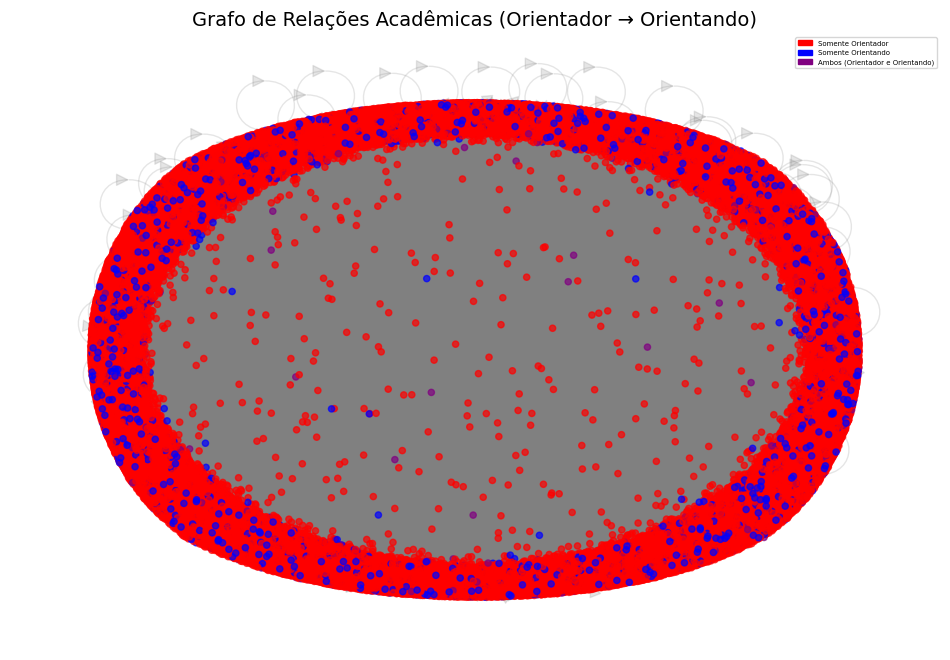

In [58]:
import matplotlib.patches as mpatches  # Para criar a legenda


# Escolhendo um layout eficiente para redes grandes
pos = nx.spring_layout(G, seed=42, k=0.5)  # Ajuste 'k' para espaçamento entre nós

# Contando as ocorrências de cada nó nas colunas
orientadores = set(df["LattesID_Orientador"])
orientandos = set(df["LattesID_Orientando"])

# Criando dicionário de cores baseado nas regras
node_colors = []
for node in G.nodes():
    if node in orientadores and node in orientandos:
        node_colors.append("purple")  # 🟣 Se aparece nas duas colunas
    elif node in orientadores:
        node_colors.append("red")  # 🔴 Se aparece só como orientador
    else:
        node_colors.append("blue")  # 🔵 Se aparece só como orientando

# Ajustando a figura
plt.figure(figsize=(12, 8))

# Desenhando os nós e arestas
nx.draw_networkx_nodes(G, pos, node_size=20, node_color=node_colors, alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color="gray", arrowsize=20)

# Criando a legenda manualmente
red_patch = mpatches.Patch(color="red", label="Somente Orientador")
blue_patch = mpatches.Patch(color="blue", label="Somente Orientando")
purple_patch = mpatches.Patch(color="purple", label="Ambos (Orientador e Orientando)")

# Adicionando a legenda ao gráfico
plt.legend(handles=[red_patch, blue_patch, purple_patch], loc="upper right", fontsize=5)

# Título e exibição
plt.title("Grafo de Relações Acadêmicas (Orientador → Orientando)", fontsize=14)
plt.axis("off")  # Remove os eixos
plt.show()

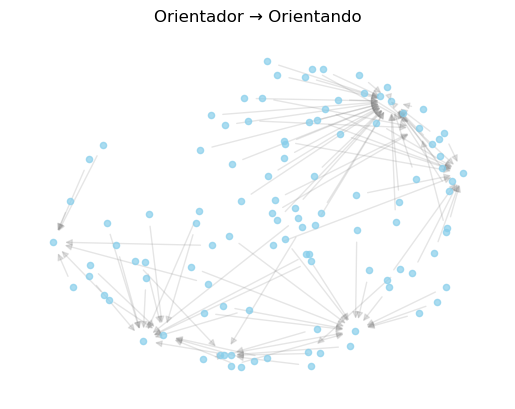

In [47]:
pos = nx.spring_layout(G, k=0.5, seed=42)  # 'k' controla a distância entre os nós

# Desenhar nós
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='skyblue', alpha=0.7)

# Desenhar arestas ponderadas
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.2)

# Adicionar rótulos aos nós (apenas alguns, para evitar poluição visual)
#sampled_nodes = dict(list(pos.items())[:50])  # Limita a visualização de rótulos a 50 nós
# nx.draw_networkx_labels(G, sampled_nodes, font_size=6, font_color='black', font_family='sans-serif')

# Ocultar eixos e mostrar o grafo
plt.axis('off')
plt.title("Orientador → Orientando")
plt.show()

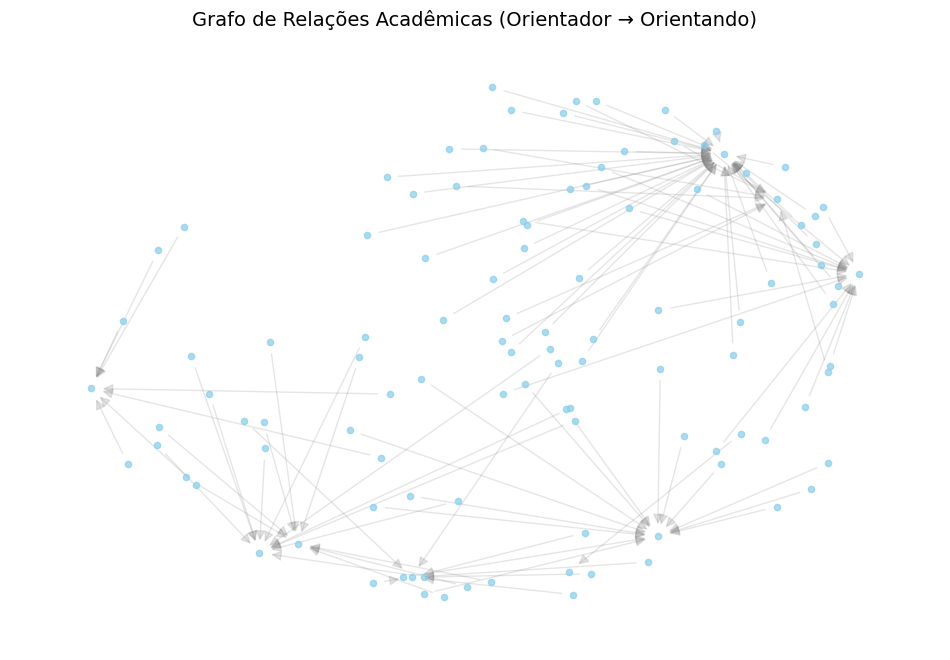

In [48]:
# Escolhendo um layout eficiente para redes grandes
pos = nx.spring_layout(G, seed=42, k=0.5)  # Ajuste 'k' para mais espaçamento entre os nós

# Ajustando a figura
plt.figure(figsize=(12, 8))

# Desenhando os nós e arestas
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='skyblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color="gray", arrowsize=15)
#nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold", font_color="black")

# Título e exibição
plt.title("Grafo de Relações Acadêmicas (Orientador → Orientando)", fontsize=14)
plt.axis("off")  # Remove os eixos
plt.show()